In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown, Latex
%run ../analyzer/helper_functions.ipynb

# Introduction

A simulation suite was built with the twAML algorithm in foundry. Input files are created with python scripts which contain a list of deposit parameters and timestamps and the behavior of the twAML parameters are dumped into an output file, which is analyzed with further python scripts.

With this approach, a number of scenarios can be simulated and the behavior of the algorithm can be demonstrated exactly as it would on-chain. There are no approximations made and the twAML algorithm is the one as used in the `twTAP.col` contract.

Each input file contains a timestamp, an operation code (either a deposit or an exit) and the amount and durations of the deposit. The following block demonstrates the header of such an input file. The foundry test then reads this file and does the appropriate `vm.warp` and `participate()` calls required to carry out the transactions.


In [2]:
ifname = "../results/inputfiles/test1.csv"
input_df = get_df(ifname, "input")
print("Input file example:")
input_df.head()

Input file example:


,timestamp,operation,account,amount,duration,timestamp_days
0,0,1,1001,4000,4,0.0
1,86400,1,1001,4400,4,1.0
2,172800,1,1001,4840,4,2.0
3,259200,1,1001,5324,4,3.0
4,345600,1,1001,5856,4,4.0


Output files are similarly structured and contain the timestamps and the corresponding twAML parameters.


In [3]:
ofname = "../results/outputs/out1_v1.csv"
output_df = get_df(ofname, "output")
display(Markdown("Output file example:"))
output_df.head()

Output file example:

,timestamp,totalParticipants,averageMagnitude,totalDeposited,cumulative,timestamp_days
0,1,1,1888854,4000.0,2493654,0.0
1,86401,2,1434755,8400.0,1058899,1.0
2,172801,3,1005550,13240.0,2064449,2.0
3,259201,4,530356,18564.0,2594805,3.0
4,345601,5,296632,24420.0,2298173,4.0


A few cases have been investigated using this method. They are presented below.

The following cases have been done on the original TWAML algorithm as present in the `twTAP.sol` contract in commit [f295bad5b1d3850f9dd55749b088c7c4082bd82c](https://github.com/Tapioca-DAO/tap-token/tree/f295bad5b1d3850f9dd55749b088c7c4082bd82c).


## Case 1: Constant duration + growing amount

### Premise

In this case, users lock an amount of TAP every day for 20 days. The lock duration is the same for all, 4 weeks long. This shows the growth of the twAML parameters.

The tAP amount locked starts at 4000 TAP, and grows by 10% every subsequent deposit. This growth is necessary since the voting threshold increases with every deposit. The locked amount and duration values specified in the input file are shown below.


Deposit parameters for case 1:


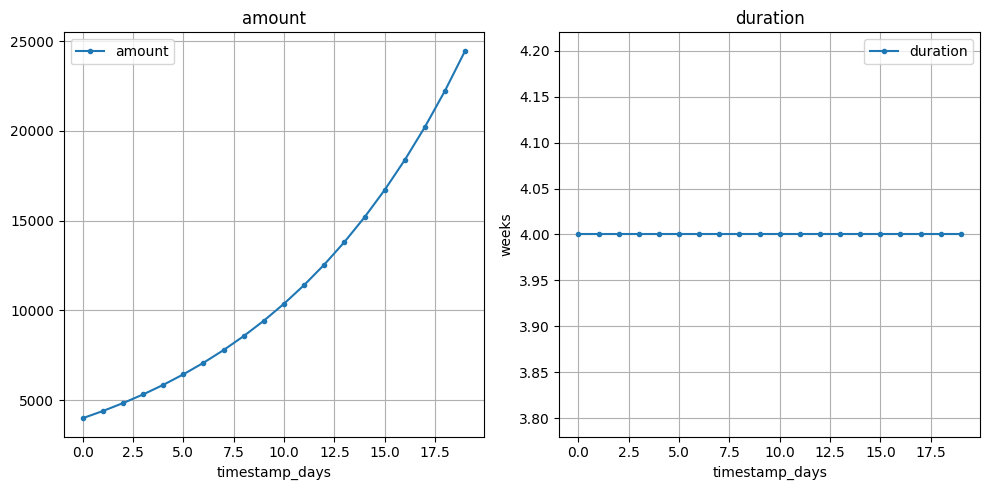

In [4]:
ifname = "../results/inputfiles/test1.csv"
input_df = get_df(ifname, "input")
print("Deposit parameters for case 1:")
plot_results(input_df, ["amount", "duration"])

### TWAML Response

The response of the twAML parameters are shown in the next block. They are similar to the ones present in the whitepaper.


TWAML response for case 1:

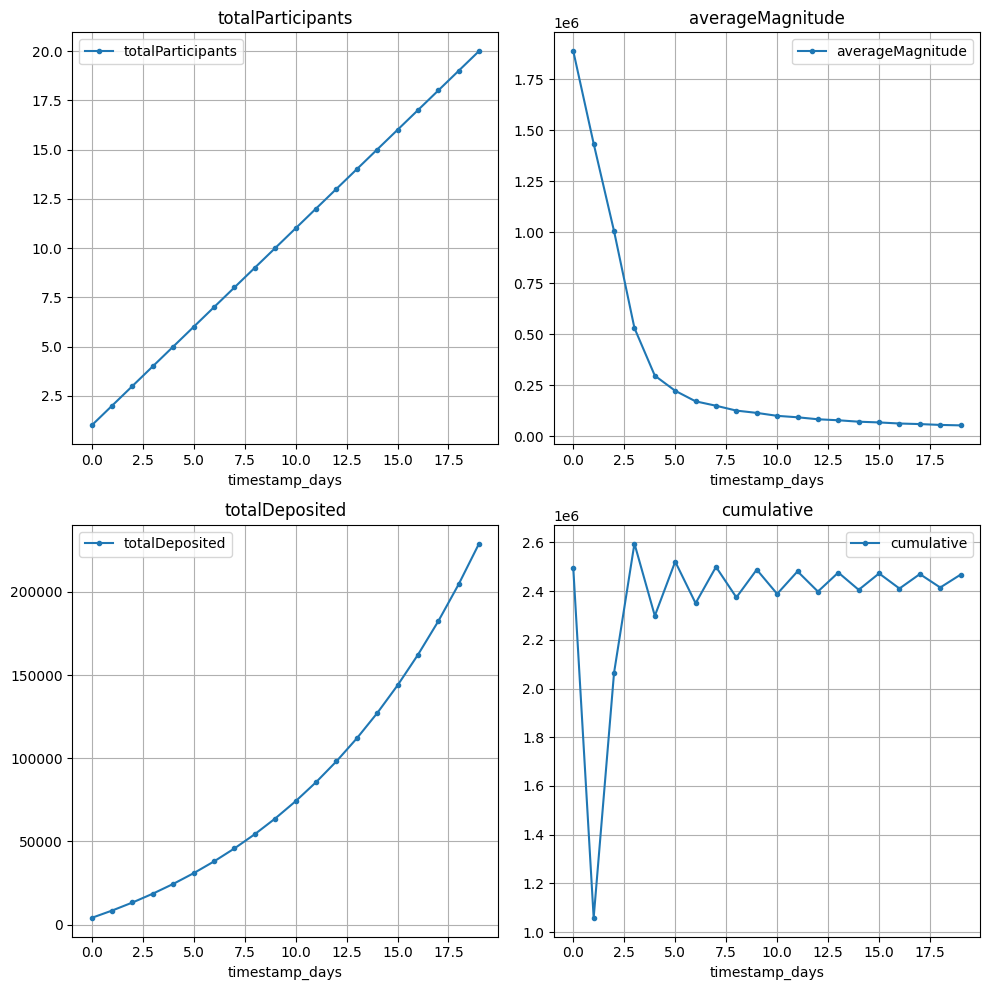

In [5]:
ofname = "../results/outputs/out1_v1.csv"
output_df = get_df(ofname, "output")
display(Markdown("TWAML response for case 1:"))
plot_results(output_df, ofcolumns[1:])

## Case 2: Growing duration + amount

### Premise

Since the system incentivizes higher lock durations, this case simulates the scenario where users increase the lock duration as well as the lock amounts on every deposit. Both values go up by 10% every subsequent deposit. The locked amount and duration values specified in the input file are charted below. Since the `duration` has to be in multiples of 1 week, the values are rounded to the nearest week. This case starts demonstrating the issue with the growing `cumulative`.


Deposit parameters for case 2:


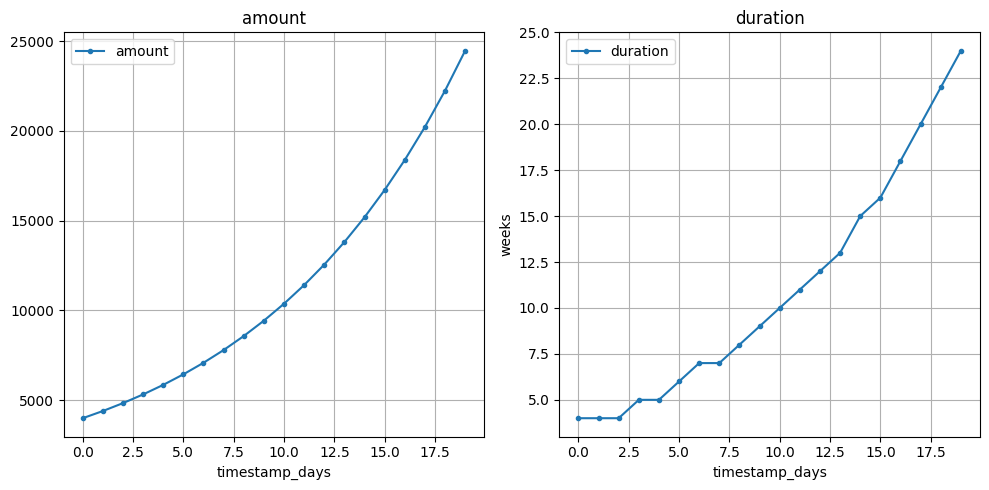

In [6]:
ifname = "../results/inputfiles/test2.csv"
input_df = get_df(ifname, "input")
print("Deposit parameters for case 2:")
plot_results(input_df, ["amount", "duration"])

### TWAML Response

The response of the twAML parameters is shown in the next block. This shows how the cumulative grows over time with the deposits, since users try to lock for longer and longer durations.


TWAML response for case 2:

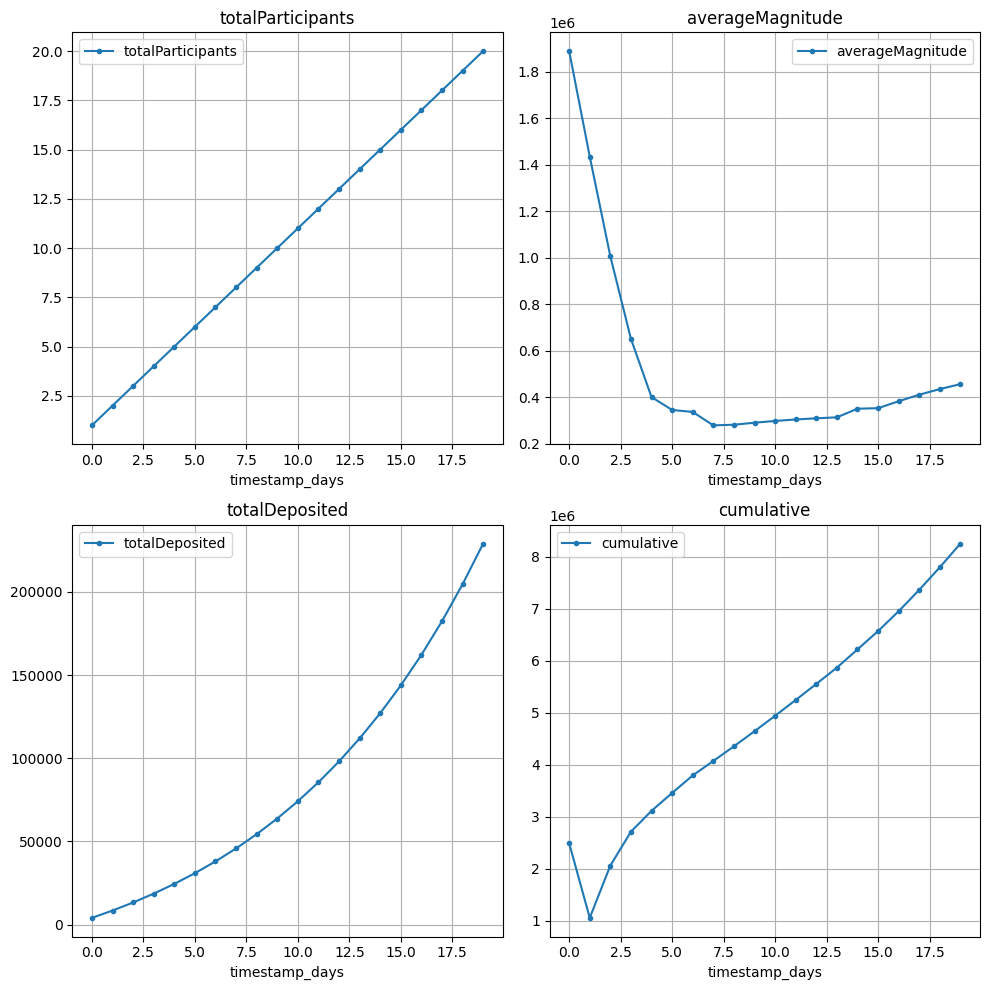

In [7]:
ofname = "../results/outputs/out2_v1.csv"
output_df = get_df(ofname, "output")
display(Markdown("TWAML response for case 2:"))
plot_results(output_df, ofcolumns[1:])

## Case 3: Fastest growth

### Premise

In order to demonstrate the exponential growth of the twAML parameters, the case for the fastest possible growth is simulated.

In this case, users deposit an amount of TAP every day for 120 days. The amount of TAP deposited is back-calculated from the twAMl contract to be the minimum amount required to clear the voting threshold. It also has a cap of 10 million TAP tokens.

The duration of the lock is the MAXIMUM duration allowed by the system. This is also back-calculated from the contract for every deposit, and basically represents the limit check `if (magnitude >= pool.cumulative * 4) revert NotValid();`.

This scenario represents the case where users keep trying to max out their locks as soon as the twAML algorithm allows it. This shows the very fastest rate at which the TWAML parameters can grow at.

By the end of the simulation, some of the initial locks are expired. Those positions are exited as soon as they expire and can be seen as little plateaus in the graph.

The following chart shows the amounts and lock durations back-calculated from the contracts for every deposit. The `amount` represents the minimum amount of TAP tokens that needs to be locked in order to have voting power and the `duration` represents the maximum allowed lock duration by the system at that point in time. Lock amount maxes out at 10 million TAP tokens and duration maxes out at 100 years as in the contract. The lock duration hits the max allowed within 11 days from the start. Since the values are updated every deposit, this can actually be achieved in a single day itself.


Lock amount and durations for case 3:

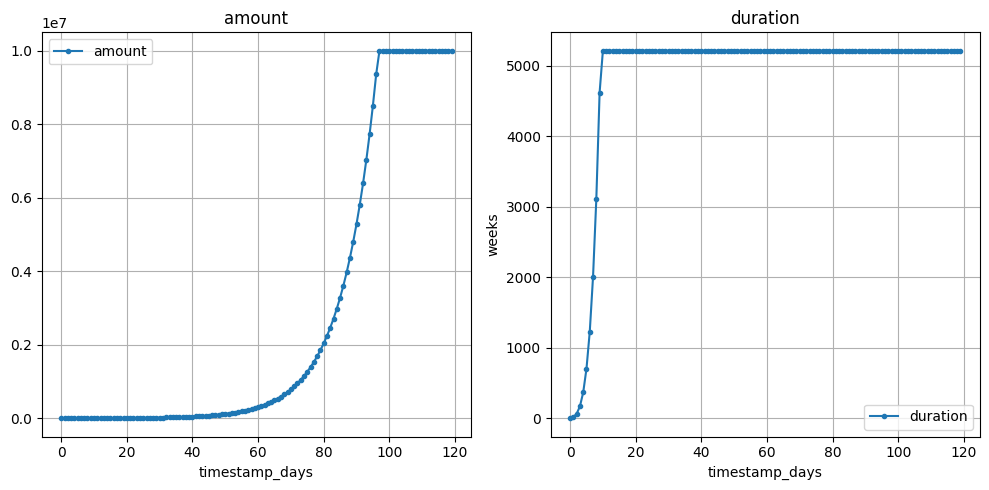

In [8]:
ifname_MG = f"../results/outputs/out_maxGrowthDeposits1_v1.csv"
input_df_MG = get_df(ifname_MG, "inputMG")
display(Markdown("Lock amount and durations for case 3:"))
plot_results(input_df_MG, ["amount", "duration"])

### TWAML Response

The response of the twAML parameters is shown in the next block. This demonstrates the fastest possible growth of these parameters allowed by the system, and the `cumulative` hits a ceiling once the max deposit time of 100 years is unlocked.


TWAML response for case 3:

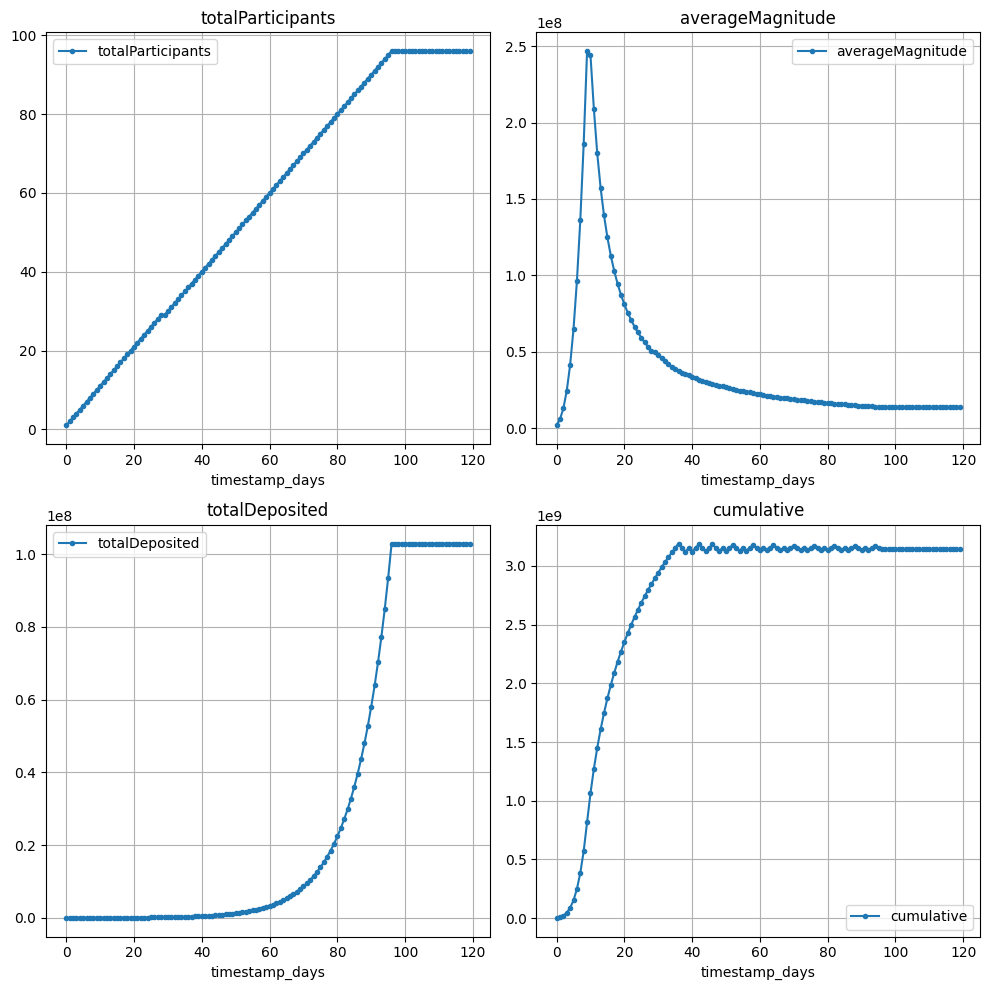

In [9]:
ofname = "../results/outputs/out_maxGrowthTWAML1_v1.csv"
output_df = get_df(ofname, "outputMG")
display(Markdown("TWAML response for case 3:"))
plot_results(output_df, ofcolumns[1:])

# V2

After launch, the TWAML parameters proved to be growing too fast. A patch was applied to stabilize the TWAML growth to a weekly update.

The following results are shown for the algorithm as implemented in `twTAP.sol` in the [PR#234](https://github.com/Tapioca-DAO/tap-token/blob/7ca212173e3a68679f45c49f64af9961d22a4c84/contracts/governance/twTAP.sol).

Case 3 from above (fastest growth) was re-ran. The other cases do not show any difference since the durations growths shown there are allowed by both algorithms.


## Case 3 - Fastest growth revisited

### Premise

The premise is the same as before, the `amount` is calculated from the contract itself to be the minimum possible to still allow voting power. The `duration` is the maximum allowed at that time.

The chart below shows the amounts and lock durations back-calculated from the contracts for every deposit. The `amount` stays the same since the new algorithm does not change the voting amount restrictions. There is however a notable difference in the `duration` field. As seen in the graph, the `maximum` allowed lock duration stays the same for an entire week. After the week has passed and the `advanceWeek` call is made, the max allowed duration is then increased. The results show that the maximum lock duration of 100 years will be achieved in 78 days, or just 11 weeks.


Lock amount and duration comparisons between the algorithms:

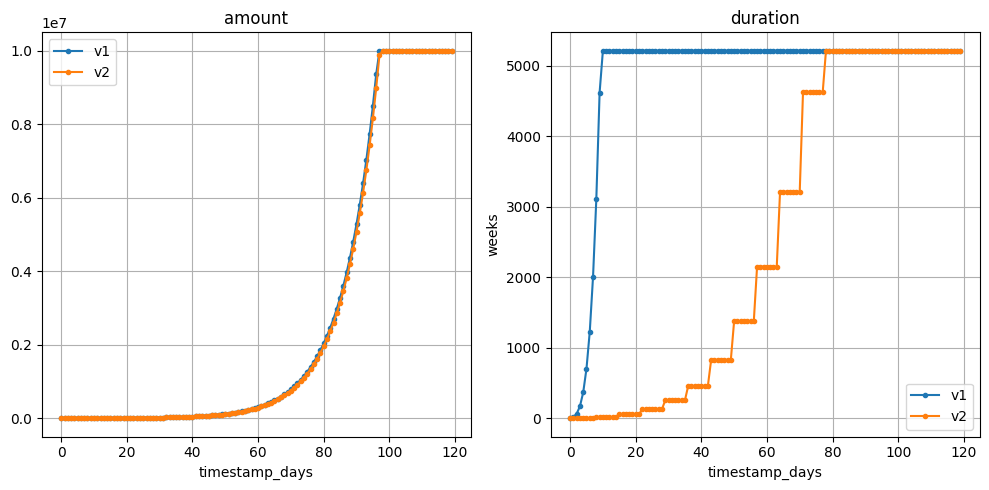

In [10]:
ifname_MG1 = f"../results/outputs/out_maxGrowthDeposits1_v1.csv"
ifname_MG2 = f"../results/outputs/out_maxGrowthDeposits1_v2.csv"
idfMG1 = get_df(ifname_MG1, "inputMG")
idfMG2 = get_df(ifname_MG2, "inputMG")
display(Markdown("Lock amount and duration comparisons between the algorithms:"))
plot_comparison(idfMG1, idfMG2, columns=["amount", "duration"])

### TWAML Response

The response of the twAML parameters is shown in the next block. Some notable differences between `v1` and `v2`.

1. In the `totalParticipants` graph, the difference is due to locks expiring. Since the max duration updates weekly, there were a bunch of 4 week locks which expire from day 28 onwards. Each expiry is accompanied by a new deposit and hence the total remains the same, showing a plateau in that region.
2. The `averageMagnitude` peak is gone. This is because it is heavily damped out by the weekly update restrictions. The value jumps up every week, but subsequent deposits with the same duration in that same week lower the value again as the divergence force decreases.
3. The `totalDeposited` has a higher cap. This is because there is an artificial restriction put in place of max 10 million TAP deposit. In v2 the last deposit under this limit was higher than the same for v1. This is insignificant in the context of TWAML.
4. The `cumulative` shows a much slower growth along with a lower final value. The rate of change at the beginning is also much lower.


TWAML response comparisons between the algorithms:

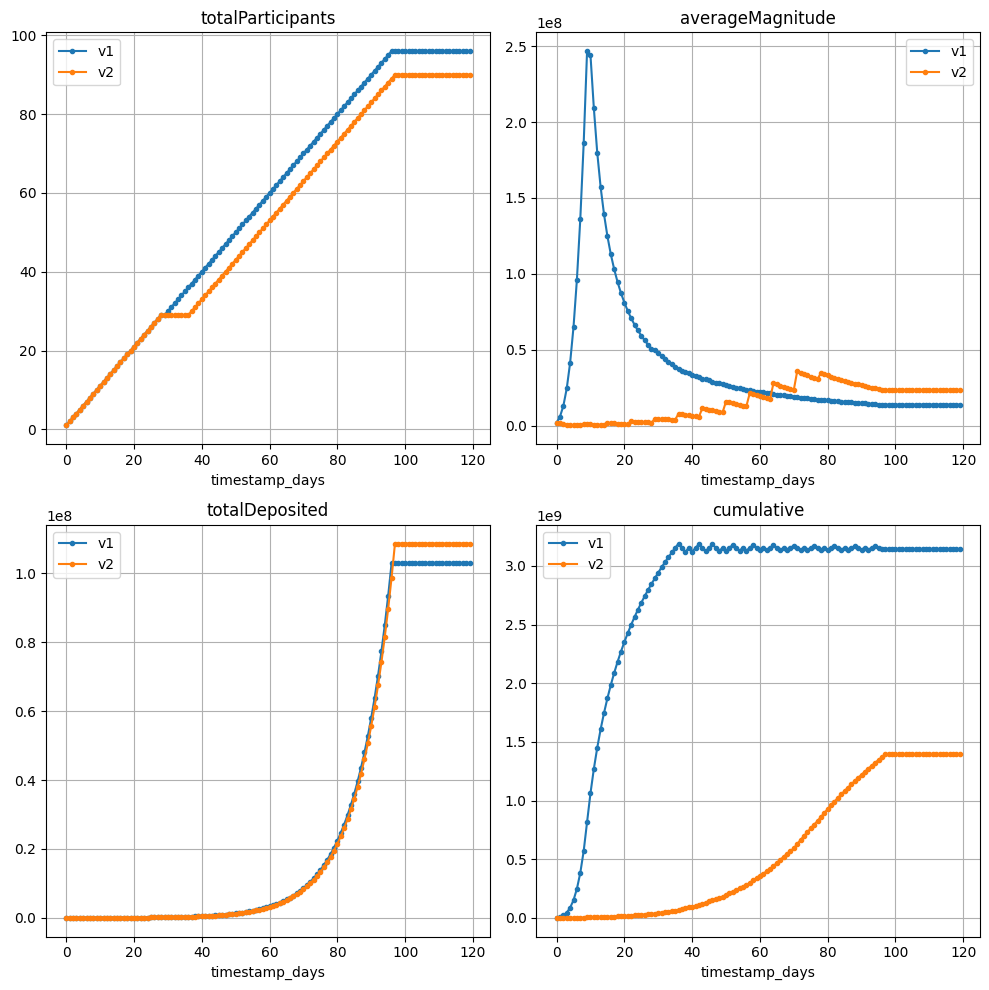

In [11]:
ofname1 = "../results/outputs/out_maxGrowthTWAML1_v1.csv"
ofname2 = "../results/outputs/out_maxGrowthTWAML1_v2.csv"
odf1 = get_df(ofname1, "outputMG")
odf2 = get_df(ofname2, "outputMG")
display(Markdown("TWAML response comparisons between the algorithms:"))
plot_comparison(odf1, odf2, columns=ofcolumns[1:])